# Overview

This week we'll talk about some of the charachteristics of real-world social networks. The structure is the following: 

* Part 1: A crash course on real-world social networks.
* Part 2: Visualizing the network of Redditors
* Part 3: Properties of the real-world network of Redditors


> *Reading*: Read [Chapter 3 of the Network Science book.](http://networksciencebook.com/chapter/3). The most important sections are 3.1 to 3.4 and 3.8 to 3.10, so focus on that.

# Part 1 : Empirical properties of real-world social networks

Researchers in Computational Social Science have widely studied the properties of real-world social networks. The very cool thing they found is that many widely different social networks (from face-to-face interactions among classmates, to the Facebook network, to collaboration networks among scientists, etc) present some commonalities. We refer to those as 'Universalities'.
In the video-lecture below, I will introduce _some_ of the things we know to be true for most real-world social networks. 

>> **_Video Lecture_**. Start by watching the ["Properties of empirical social networks"](https://youtu.be/jHdnehLku54). 


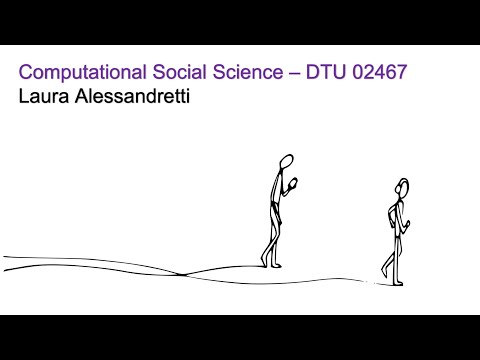

In [6]:
from IPython.display import YouTubeVideo
YouTubeVideo("jHdnehLku54",width=800, height=450)

> *Exercise 1:* Did you really read the text? Answer the following questions (no calculations needed) in your Jupyter notebook.

> * What's the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?
    - If nodes are randomly connected to each other, we lack outliers. In cases like social networks we lack popular people or people who are left behind.

> * List the four regimes that characterize random networks as a function of ⟨k⟩.
    - subcritical regime, critical point, supercritical regime, connected regime
    
> * According to the book, why is it a problem for random networks (in terms of being a model for real-world networks that the degree-dependent clustering C(k) decreases as a function of k in real-world networks?
    - Because it does not fit with random networks, where C(k) is independent of the degree

# Part 2 : Visualizing the network of Redditors

Take the network of redditors you built in Week3, Part 3. To get an idea about how the network looks like, we start visualizing it. For this exercise, we will use the __awesome library [``netwulf``](https://netwulf.readthedocs.io/en/latest/index.html)__ created by Ulf Aslak, a colleague of mine and former DTU PhD student. You can install it via ``pip install netwulf``. 

Netwulf is built on top of [d3-force](https://github.com/d3/d3-force), a Javascript library that simulates the dynamics of particles moving in 2D. In the visualization, particles correspond to network nodes subject to forces:
 * Nodes are attracted to the center of the viz 
 * Nodes repel each other
 * Nodes linked by an edge will preferably stay at a fixed distance to each other.


> _Exercise_ 1: Visualize the network of Redditors. 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import datetime

def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

# load data
comments = pd.read_csv('Data/wallstreetbets_comments.csv', parse_dates=['created_utc'], date_parser=dateparse)
submissions = pd.read_csv("Data/wallstreetbets_submissions.csv", parse_dates = ["created_utc"], date_parser=dateparse)

In [12]:
comments.head(10)

,id,score,created_utc,author,parent_id,created
0,gkjkq9i,82,2021-01-24 13:06:31,skinfather11216,t3_l3y4mp,1.611486e+09
1,gkjkjmx,9,2021-01-24 13:05:44,DivingDeep21,t1_gkjja9s,1.611486e+09
2,gkjkiyd,28,2021-01-24 13:05:39,je_veux_sentir,t1_gkjjk3k,1.611486e+09
3,gkjkiki,18,2021-01-24 13:05:36,BlazingLeo,t1_gkjjk3k,1.611486e+09
4,gkjkdnm,11,2021-01-24 13:05:01,Anon-1400secret,t1_gkjjzr8,1.611486e+09
5,gkjkbg4,34,2021-01-24 13:04:45,je_veux_sentir,t1_gkjjcjj,1.611486e+09
6,gkjkax0,9,2021-01-24 13:04:42,bschug,t1_gkji91v,1.611486e+09
7,gkjk9ke,15,2021-01-24 13:04:32,WesternBenefit,t3_l3xmhk,1.611486e+09
8,gkjk6wp,13,2021-01-24 13:04:11,je_veux_sentir,t1_gkjja9s,1.611486e+09
9,gkjk6q0,1,2021-01-24 13:04:10,[deleted],t3_l3vqn9,1.611486e+09


In [15]:
# dictionaries
comment_authors = dict(zip(comments["id"], comments["author"]))
parent = dict(zip(comments["id"], comments["parent_id"]))
submissions_authors = dict(zip(submissions["id"], submissions["author"]))

# function for getting author of parent id
def get_parent_author(comment_id):
    parent_id = parent[comment_id]
    t_parent_id = parent_id[:3]
    parent_id = parent_id[3:]

    try: 
        if t_parent_id == "t1_":
                return comment_authors[parent_id]# if parent_id in comment_authors.keys else None
        elif t_parent_id == "t3_":
            return submissions_authors[parent_id]
        else:
            return -1
    except KeyError:
        return -1

# create parent_author column in comments dataframe
comments["parent_author"] = list(map(get_parent_author, comments["id"]))
# remove unwanted authors
comments = comments[comments.parent_author != -1] # remove rows with keyerror (around 14k rows)
comments = comments[comments.created_utc <= "2020-12-31"] # remove comments from after 31/12-2020
comments = comments[(comments.author != "[deleted]") & (comments.parent_author != "[deleted]")]# remove deleted users

In [18]:
# build network

#Create the weighted edge-list of your network
comments_network = comments.groupby(["author", "parent_author"]).size()
comments_network = comments_network.reset_index()
comments_network.columns = ["author", "parent_author","weight"]

# create graph

# "A direct link going from node A to node B exists if A ever answered a submission or a comment by B"
G = nx.from_pandas_edgelist(comments_network, "author", "parent_author", "weight", create_using = nx.DiGraph()) # adds directed edges from parent_author to author

> * For this and the following exercise, we will study the undirected graph of "reciprocal" edges. Reciprocal edges are such that each of the two authors forming the edge has replied to the other at least once. Build the reciprocal graph using the function [``to_undirected``](https://networkx.org/documentation/stable//reference/classes/generated/networkx.DiGraph.to_undirected.html)(set ``reciprocal=True``). Assign to each undirected edge a weight equal to the sum of the weights in the two corresponding directed edges. Remove self-loops (edges connecting a node to itself). Remove from the network all the nodes without connections. 

In [21]:
reciprocal_G = G.to_undirected(reciprocal=True)
#remove self-loops
for edge in list(nx.selfloop_edges(reciprocal_G)):
    reciprocal_G.remove_edge(edge[0], edge[1])
#remove all nodes without connections
reciprocal_G.remove_nodes_from(list(nx.isolates(reciprocal_G)))
#assign edge weights
G_weighted_edges = nx.get_edge_attributes(G, 'weight')

for e in reciprocal_G.edges():
    w = 0
    e1 = (e[0], e[1])
    e2 = (e[1], e[0])
    if e1 in G_weighted_edges:
        w += G_weighted_edges[(e[0],e[1])]
    if e2 in G_weighted_edges:
        w += G_weighted_edges[(e[1],e[0])]

    G[e[0]][e[1]]['weight'] = w

> * How many nodes are present in the reciprocal graph? How many edges? Which fraction of the original network nodes and edges they represent? How do you interpret this result?

In [24]:
print(f'Nodes: {len(reciprocal_G.nodes)}')
print(f'Edges: {len(reciprocal_G.edges)}')

print(f'Reciprocal node fraction of original: {len(reciprocal_G.nodes)/len(G.nodes)}')
print(f'Reciprocal edge fraction of original: {len(reciprocal_G.edges)/len(G.edges)}')

Nodes: 6132
Edges: 7437
Reciprocal node fraction of original: 0.27690223526755475
Reciprocal edge fraction of original: 0.13064788138570727


Reciprocal node fration is 29%. This would mean that many users have not both posted and received comments.

Reciprocal edge fration is around 13%. This would mean that the reciprocal graph has less edges. So, quite a few users have more than one edge to and from each other. 

All in all, it looks like there are quite a lot of users who gets no interactions with others and a smaller group of users who interacts quite a lot with each other.

> * Visualize the undirected graph you just created using the function [``visualize``](https://netwulf.readthedocs.io/en/latest/reference/interactive.html?highlight=visualize#netwulf.interactive.visualize) of the Netwulf package. 


In [27]:
from netwulf import visualize

#need to restart notebook each time to run this visualization due to the local server which renders the graph
visualize(reciprocal_G)

41,
    'y': 229.03539558647446,
    'x_canvas': 400.0488162305842,
    'y_canvas': 229.03539558647446,
    'radius': 5,
    'color': '#79aaa0'},
   {'id': 'new2cigars',
    'x': 389.28149787671947,
    'y': 221.5666520743177,
    'x_canvas': 389.28149787671947,
    'y_canvas': 221.5666520743177,
    'radius': 5,
    'color': '#79aaa0'},
   {'id': 'orangeandblue122',
    'x': 400.5421016717003,
    'y': 196.38054498751674,
    'x_canvas': 400.5421016717003,
    'y_canvas': 196.38054498751674,
    'radius': 5,
    'color': '#79aaa0'},
   {'id': 'papabear570',
    'x': 354.27823024511423,
    'y': 249.91087974855643,
    'x_canvas': 354.27823024511423,
    'y_canvas': 249.91087974855643,
    'radius': 5,
    'color': '#79aaa0'},
   {'id': 'peterman2012',
    'x': 424.0549675695644,
    'y': 590.3020549057306,
    'x_canvas': 424.05496756956444,
    'y_canvas': 590.3020549057306,
    'radius': 5,
    'color': '#79aaa0'},
   {'id': 'plomii',
    'x': 183.0150287203567,
    'y': 61.87152035

> * Play with the parameters of the netwulf algorithm to obtain a visualization you like. To understand better what the parameters mean, have a look at the [documentation](https://netwulf.readthedocs.io/en/latest/visualization/init.html?). Your visualization may look similar to the one below, where I made the size of nodes proportional to their strength (sum of weights on the outgoing edges), and I added the names of the top redditors by degree... But not necessarily! Just have fun making your own version. You can save the figure directly from the interactive visualization panel, or plot it in higher resolution in matplotlib following [this example](https://netwulf.readthedocs.io/en/latest/cookbook/cookbook.html#save-as-pdf).

> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? 
- Yes, there are nodes such as *Stonksflyingup*, *Ackilles*, *DeepFuckingValue*, *restioned*. these nodes have high degrees, meaning that they have a lot of interactions in the network. Probably, they are very active and/or popular users.

> * _Optional_: You can color nodes based on a property of your interest. For example, I colored nodes based on the date of authors' first comment, following [this example](https://github.com/benmaier/netwulf/issues/38). What do you observe? Can you find specific nodes properties that seem to correlate with a node's position in the network?

<img src="https://github.com/lalessan/comsocsci2021/raw/master/files/network.png" alt="Drawing" style="width: 800px;"/>

# Part 3: Properties of the real-world network of Redditors


> _Exercise 2_: 
>

> 2.1 _Random Network_: In this exercise we will create a Random Network as a null model to investigate some properties of the Redditors Network.

> * Compute the value of _p_ such that the number of expected edges of the random network equals the number of edges in the redditor network (see equation 3.2 in your Network Science Book). What is the value of p? Compute the average value of the degree < k > (using the formula).

In [30]:
#from chapter 3.3
N = len(reciprocal_G.nodes)
L = len(reciprocal_G.edges)

p = (2*L)/(N*(N-1))
p

0.0003956346448911741

In [33]:
#also from chapter 3.3
k = p*(N-1)
k

2.4256360078277885

> * Use NetworkX to create a Random network with the same number of nodes as the redditor networks, and _p_ as computed above. You can use the function [``erdos_renyi_graph``](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph) in NetworkX. 

In [36]:
import networkx as nx

seed = 42
#using N and p from previous cells
rnd_G = nx.erdos_renyi_graph(N,p)

> * Visualize the network as you did for the Redditors network in the exercise above (my version is below). Comment on the differences between the two.
>

In [39]:
import networkx
from netwulf import visualize

#need to restart notebook each time to run this visualization due to the local server which renders the graph
data = visualize(rnd_G, plot_in_cell_below=True)

I have probably chosen a different zoom and node size parameter, which gives a different look to the whole network.

Also it seems like the sphere of your network is more connected than in my network. 

> 2.2 _Degree Distribution_: In this exercise, we will compare the degree distribution of the real network and its random counterpart.

> * Compute the distribution of degree for the random network using the numpy function ``np.histogram``. Bin your histogram using 10 linearly spaced bins. Remember to pass the parameter ``density=True``.

In [ ]:
import numpy as np

degrees = list(rnd_G.degree())
degrees = [(x,y) for x,y in degrees if y > 0]
xx = [x for x,y in degrees]
yy = [y for x,y in degrees]
bins = np.linspace(0, 10, 10)
hist, hist_edges = np.histogram(yy, bins=bins, density=True)
x = (hist_edges[1:]+hist_edges[:-1])/2

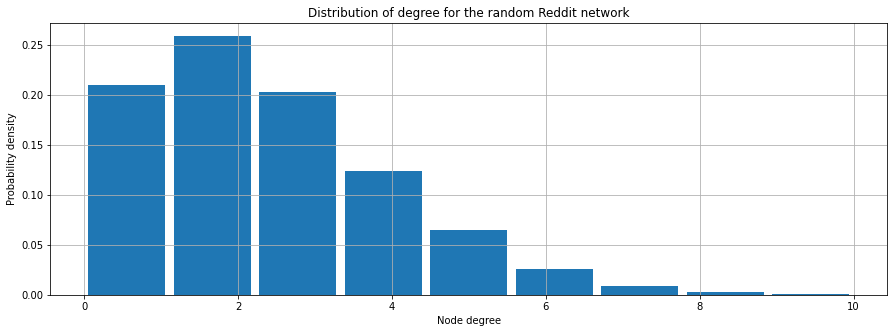

In [32]:
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(15,5))
width = bins[1]-bins[0]
ax.bar(x, hist, width=width*0.9)
ax.grid()
ax.set_title('Distribution of degree for the random Reddit network')
ax.set_xlabel('Node degree')
ax.set_ylabel('Probability density')
plt.show()

> * Compute the distribution of degree for the Redditors undirected network using the numpy function ``np.histogram``. Bin your histogram using 10 logarithmically spaced bins. Remember to pass the parameter ``density=True``.

In [44]:
import numpy as np

degrees = list(rnd_G.degree())
degrees = [(x,y) for x,y in degrees if y > 0]
xx = [x for x,y in degrees]
yy = [y for x,y in degrees]
bins = np.logspace(0, np.log10(10), 10)
hist, hist_edges = np.histogram(yy, bins=bins, density=True)
x = (hist_edges[1:]+hist_edges[:-1])/2

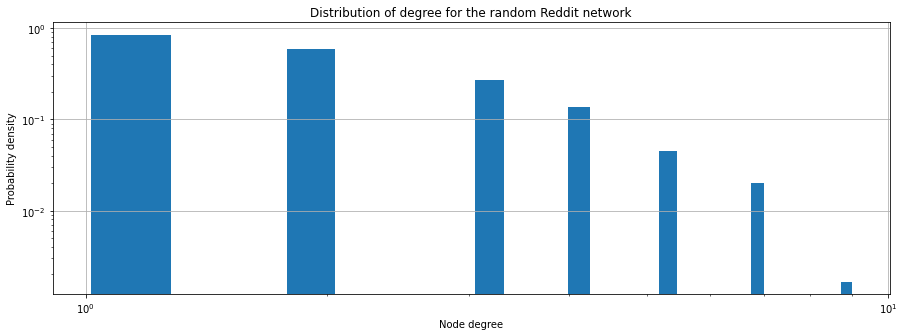

In [45]:
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(15,5))
width = bins[1]-bins[0]
ax.bar(x, hist, width=width*0.9)
ax.grid()
ax.set_title('Distribution of degree for the random Reddit network')
ax.set_xlabel('Node degree')
ax.set_ylabel('Probability density')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

> * Plot the two distributions you computed in steps 1. and 2. in the same figure as two line-graphs. Log-scale the x and y axes. 

<ipython-input-49-a3afc00725af>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


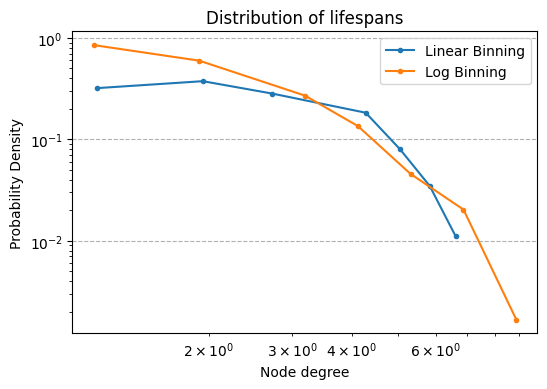

In [49]:
# create histogram and plot it
degrees = list(rnd_G.degree())
degrees = [(x,y) for x,y in degrees if y > 0]
xx = [x for x,y in degrees]
yy = [y for x,y in degrees]

#linear binning
bins_lin = np.linspace(0, 7, 10)
hist_lin, hist_edges_lin = np.histogram(yy, bins=bins_lin, density=True)
x_lin = (hist_edges_lin[1:]+hist_edges_lin[:-1])/2

#log binning
bins_log = np.logspace(0, np.log10(376), 10)
hist_log, hist_edges_log = np.histogram(yy, bins=bins, density=True)
x_log = (hist_edges_log[1:]+hist_edges_log[:-1])/2

# remove 0 entries
def remove_zero_entries(x, hist):
    return zip(*[(i,j) for (i,j) in zip(x, hist) if j > 0])

xx_lin, yy_lin = remove_zero_entries(x_lin, hist_lin)
xx_log, yy_log = remove_zero_entries(x_log, hist_log)

fig, ax = plt.subplots(dpi = 100)

ax.plot(xx_lin,yy_lin, marker = ".", label = "Linear Binning")
ax.plot(xx_log,yy_log, marker = ".", label = "Log Binning")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Node degree")
ax.set_ylabel("Probability Density")
ax.grid(linestyle = '--')
ax.legend()

ax.set_title("Distribution of lifespans")
fig.show()

> * Comment the figure. What are the differences between the two distributions? Why did I ask you to use two different types of binning? 

TODO

> * What is the average degree of the random and the real network? Comment on the relation between the two. 
>

In [18]:
def P(L,N):
    return (2*L)/(N*(N-1))

def K(p,N):
    return p*(N-1)

In [19]:
#real network
print(f'Real Network')
print(f'p: {p}')
print(f'k: {k}')

Nr = len(rnd_G.nodes)
Lr = len(rnd_G.edges)
pr = P(Lr, Nr)
kr = K(pr, Nr)

print('\nRandom Network')
print(f'p: {pr}')
print(f'k: {kr}')

Real Network
p: 0.0003726751945160055
k: 2.444749276024996

Random Network
p: 0.00037169936171241
k: 2.4383478128334097


In [20]:
#real network
avg_degree = sum([d for n,d in reciprocal_G.degree])/len(reciprocal_G.nodes)
print('Real Reciprocal Network')
print(f'Average degree: {avg_degree}')

#random network
rnd_avg_degree = sum([d for n,d in rnd_G.degree])/len(rnd_G.nodes)
print('Real Reciprocal Network')
print(f'Average degree: {rnd_avg_degree}')

Real Reciprocal Network
Average degree: 2.444749276024996
Real Reciprocal Network
Average degree: 2.4383478128334097


Average degree is pretty much the same for each network.
It could mean, that the average degree, i.e. the amount of other users a user interacts with, can be accounted for by randomness.

> 2.3 _Shortest Paths_: Here, we will check if the Redditors Network is a small-world Network.

> * Compute the average shortest path for the largest connected component of the Redditors network (for a reminder of the definition of connected components, check [section 2.9 of the Network Science book](http://networksciencebook.com/chapter/2#connectedness)). You can use the following steps: 
>    * Use [``nx.algorithms.connected_components``](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.components.connected_components.html) to find all connected components (it returns a list of subsets of the original set of nodes). 
>    * Consider the largest subset of nodes found in the step above. Build the subgraph of your original network containing those nodes exclusively, using [``nx.Graph.subgraph``](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html). This corresponds to your largest connected component (a.k.a [giant component](https://en.wikipedia.org/wiki/Giant_component)).
>

In [50]:
import networkx as nx

components = list(nx.algorithms.connected_components(reciprocal_G))
giant_component = max(nx.connected_components(reciprocal_G), key=len)
giant_component = reciprocal_G.subgraph(giant_component)

> * Compute the average shortest path length of the giant component using [``nx.average_shortest_path_length``](https://networkx.org/documentation/networkx-1.3/reference/generated/networkx.average_shortest_path_length.html)


In [51]:
nx.average_shortest_path_length(giant_component)

5.56651001498743

> * Compute the average shortest path length for the giant component of the random network you built in exercise 2.1.

In [140]:
rnd_components = list(nx.algorithms.connected_components(rnd_G))
rnd_giant_component =  max(nx.connected_components(rnd_G), key=len)
rnd_giant_component = rnd_G.subgraph(rnd_giant_component)
nx.average_shortest_path_length(rnd_giant_component)

9.53991461530288

> * Comment on the relation between the average shortest path length in the real and the random networks. Can you conclude that the small-world property apply to the Redditors network? 

The average shortest path for the reciprocal Reddit network is around 5.5, so close to that of 6, which is what the small-world (six degrees of separation) property suggests. So yes, the small-world property apply to the Reddit network.

In the random network, the average shortest path is a lot bigger than 6, so the small-world property does not apply here.

> 2.4 _Clustering_: Here, we will compare the clustering coefficient in the Redditors Network and its random counterpart.
> * Compute the clustering coefficient for all nodes in the random network, using networkx [``clustering``](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) function. Compute the average across nodes. Is it consistent with the analytical prediction (network science book equation 3.21)?
> * Compute the average clustering coefficient for the Redditors network. How does it compare to its random counterpart? Is it something you would expect? Why?


<img src="https://github.com/lalessan/comsocsci2021/raw/master/files/random_network.png" alt="Drawing" style="width: 800px;"/>

In [29]:
clustering_coef_all_nodes = nx.clustering(rnd_G)
avg_clust_coef_all_nodes = nx.average_clustering(rnd_G)
avg_clust_coef_all_nodes

0.00023080105384632132

In [30]:
kr/Nr

0.0003716427088604496

It's pretty close

In [31]:
nx.average_clustering(reciprocal_G)

0.012414133067246095

Much higher which is also expected since it's a real network, as announced in the book (box 3.9)